In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
#动手练习：创建图像自动分类器

In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=False, transform=transform) #已下载用download=False，否则为True
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
nums_epoch = 2
for epoch in range(nums_epoch):
    _loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _loss += loss.item()
        if i % 3000 == 2999:
            print('[%d, %5d] 损失: %.3f' %
                  (epoch + 1, i + 1, _loss / 3000))
            _loss = 0.0

print('训练结束')

[1,  3000] 损失: 2.079
[1,  6000] 损失: 1.693
[1,  9000] 损失: 1.558
[1, 12000] 损失: 1.496
[2,  3000] 损失: 1.426
[2,  6000] 损失: 1.368
[2,  9000] 损失: 1.313
[2, 12000] 损失: 1.288
训练结束


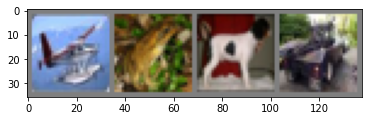

图像真实分类:  plane  frog   dog truck


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('图像真实分类: ', ' '.join(['%5s' % classes[labels[j]] for j in range(4)]))

In [8]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('图像预测分类: ', ' '.join(['%5s' % classes[predicted[j]] for j in range(4)]))

图像预测分类:  plane  frog   dog truck


In [9]:
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
    
print('测试集准确率: %d %%' % (100 * correct / total))

测试集准确率: 55 %


In [10]:
#动手练习：搭建图像自动识别模型

In [11]:
import torch
import torchvision
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F

In [12]:
train_data = torchvision.datasets.MNIST(
    root = './',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = False)

test_data = torchvision.datasets.MNIST(
    root='./',
    train=False)

test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.targets

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output = nn.Linear(32*7*7,10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0),-1)
        out = self.output(out)
        return out

cnn = CNN()
LR = 0.001
EPOCH = 3
BATCH_SIZE= 50

optimizer = torch.optim.Adam(cnn.parameters(),lr=LR,)
loss_func = nn.CrossEntropyLoss()

train_loader = Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_data = torchvision.datasets.MNIST(root='./',train=False)

for epoch in range(EPOCH):
    for step ,(b_x,b_y) in enumerate(train_loader):
        output = cnn(b_x)
        loss = loss_func(output,b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%50 ==0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))

torch.save(cnn,'cnn_minist.pkl')

In [14]:
cnn = torch.load('cnn_minist.pkl')

test_output = cnn(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy()

print('预测值', pred_y)
print('实际值', test_y[:20].numpy())

test_output1 = cnn(test_x)
pred_y1 = torch.max(test_output1, 1)[1].data.numpy()
accuracy = float((pred_y1 == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('准确率',accuracy)

预测值 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4]
实际值 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
准确率 0.9849


In [15]:
import torch
import torchvision
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F

train_data = torchvision.datasets.MNIST(
    root = './',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = False)

test_data = torchvision.datasets.MNIST(
    root='./',
    train=False)

test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)/255
test_y = test_data.targets

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output = nn.Linear(32*7*7,10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0),-1)
        out = self.output(out)
        return out

cnn = CNN()

optimizer = torch.optim.Adam(cnn.parameters(),lr=LR,)
loss_func = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step ,(b_x,b_y) in enumerate(train_loader):
        output = cnn(b_x)
        loss = loss_func(output,b_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step%50 ==0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            
torch.save(cnn,'cnn_minist.pkl')

cnn = torch.load('cnn_minist.pkl')

test_output = cnn(test_x[:20])
pred_y = torch.max(test_output, 1)[1].data.numpy()

print('预测值', pred_y)
print('实际值', test_y[:20].numpy())

test_output1 = cnn(test_x)
pred_y1 = torch.max(test_output1, 1)[1].data.numpy()
accuracy = float((pred_y1 == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
print('准确率',accuracy)

预测值 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 8 4]
实际值 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
准确率 0.9832


In [16]:
#动手练习：搭建图像自动分割模型

In [17]:
import os
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, train_path, transform=None):
        self.images = os.listdir(train_path + '/last')
        self.labels = os.listdir(train_path + '/last_msk')
        assert len(self.images) == len(self.labels), 'Number does not match'
        self.transform = transform
        self.images_and_labels = []
        for i in range(len(self.images)):
            self.images_and_labels.append((train_path + '/last/' + self.images[i], train_path + '/last_msk/' + self.labels[i]))

    def __getitem__(self, item):
        img_path, lab_path = self.images_and_labels[item]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        lab = cv2.imread(lab_path, 0)
        lab = cv2.resize(lab, (224, 224))
        lab = lab / 255
        lab = lab.astype('uint8')
        lab = np.eye(2)[lab]
        lab = np.array(list(map(lambda x: abs(x-1), lab))).astype('float32')
        lab = lab.transpose(2, 0, 1)
        if self.transform is not None:
            img = self.transform(img)
        return img, lab

    def __len__(self):
        return len(self.images)

if __name__ == '__main__':
    img = cv2.imread('data/train/last_msk/50.jpg', 0)
    img = cv2.resize(img, (16, 16))
    img2 = img/255
    img3 = img2.astype('uint8')
    hot1 = np.eye(2)[img3]
    hot2 = np.array(list(map(lambda x: abs(x-1), hot1)))
    print(hot2.shape)

(16, 16, 2)


In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encode1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.encode2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.encode3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.encode4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.encode5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )
        self.decode1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3,
                               stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.decode2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.decode3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.decode4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        self.decode5 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )
        self.classifier = nn.Conv2d(16, 2, kernel_size=1)

    def forward(self, x):
        out = self.encode1(x)
        out = self.encode2(out)
        out = self.encode3(out)
        out = self.encode4(out)
        out = self.encode5(out)
        out = self.decode1(out)
        out = self.decode2(out)
        out = self.decode3(out)
        out = self.decode4(out)
        out = self.decode5(out)
        out = self.classifier(out)
        return out

if __name__ == '__main__':
    img = torch.randn(2, 3, 224, 224)
    net = Net()
    sample = net(img)
    print(sample.shape)

torch.Size([2, 2, 224, 224])


In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader

batchsize = 8
epochs = 20
train_data_path = 'data/train'

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
bag = MyDataset(train_data_path, transform)
dataloader = DataLoader(bag, batch_size=batchsize, shuffle=True)

device = torch.device('cpu')
#device = torch.device('cuda')
net = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.7)

if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

for epoch in range(1, epochs+1):
    for batch_idx, (img, lab) in enumerate(dataloader):
        img, lab = img.to(device), lab.to(device)
        output = torch.sigmoid(net(img))
        loss = criterion(output, lab)

        output_np = output.cpu().data.numpy().copy()
        output_np = np.argmin(output_np, axis=1)
        y_np = lab.cpu().data.numpy().copy()
        y_np = np.argmin(y_np, axis=1)

        if batch_idx % 20 == 0:
            print('Epoch:[{}/{}]\tStep:[{}/{}]\tLoss:{:.6f}'.format(
                epoch, epochs, (batch_idx+1)*len(img), len(dataloader.dataset), loss.item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        torch.save(net, './model/model_epoch_{}.pth'.format(epoch))
        print('./model/model_epoch_{}.pth saved!'.format(epoch))

Epoch:[1/20]	Step:[8/50]	Loss:0.722205
Epoch:[2/20]	Step:[8/50]	Loss:0.707521
Epoch:[3/20]	Step:[8/50]	Loss:0.703916
Epoch:[4/20]	Step:[8/50]	Loss:0.695661
Epoch:[5/20]	Step:[8/50]	Loss:0.690604
Epoch:[6/20]	Step:[8/50]	Loss:0.685048
Epoch:[7/20]	Step:[8/50]	Loss:0.672947
Epoch:[8/20]	Step:[8/50]	Loss:0.682316
Epoch:[9/20]	Step:[8/50]	Loss:0.643794
Epoch:[10/20]	Step:[8/50]	Loss:0.652043
./model/model_epoch_10.pth saved!
Epoch:[11/20]	Step:[8/50]	Loss:0.654755
Epoch:[12/20]	Step:[8/50]	Loss:0.626490
Epoch:[13/20]	Step:[8/50]	Loss:0.629811
Epoch:[14/20]	Step:[8/50]	Loss:0.587082
Epoch:[15/20]	Step:[8/50]	Loss:0.582059
Epoch:[16/20]	Step:[8/50]	Loss:0.571589
Epoch:[17/20]	Step:[8/50]	Loss:0.564160
Epoch:[18/20]	Step:[8/50]	Loss:0.569188
Epoch:[19/20]	Step:[8/50]	Loss:0.542955
Epoch:[20/20]	Step:[8/50]	Loss:0.527140
./model/model_epoch_20.pth saved!


In [20]:
class TestDataset(Dataset):
    def __init__(self, test_img_path, transform=None):
        self.test_img = os.listdir(test_img_path)
        self.transform = transform
        self.images = []
        for i in range(len(self.test_img)):
            self.images.append(os.path.join(test_img_path, self.test_img[i]))

    def __getitem__(self, item):
        img_path = self.images[item]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self):
        return len(self.test_img)

test_img_path = './data/test/last'
checkpoint_path = './model/model_epoch_20.pth'
save_dir = 'data/test/result'
if not os.path.exists(save_dir ):
    os.mkdir(save_dir )

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
bag = TestDataset(test_img_path, transform)
dataloader = DataLoader(bag, batch_size=1, shuffle=None)

net = torch.load(checkpoint_path)
#net = net.cuda()
for idx, img in enumerate(dataloader):
#    img = img.cuda()
    output = torch.sigmoid(net(img))

    output_np = output.cpu().data.numpy().copy()
    output_np = np.argmin(output_np, axis=1)

    img_arr = np.squeeze(output_np)
    img_arr = img_arr*255
    cv2.imwrite('%s/%03d.png'%(save_dir, idx), img_arr)
    print('%s/%03d.png'%(save_dir, idx))

data/test/result/000.png
data/test/result/001.png
data/test/result/002.png
data/test/result/003.png
data/test/result/004.png
